# Predictive Analytics 
The lecture has introduced the standard data structure for predictive analytics. We need data with input variables and a **target variable**. The goal of predictive analytics is to derive a functional relationship between the input variables and the target. We assume that we can observe, measure, or control the input variables. Hence, our predictive model (the functional relationship between inputs and the target that we infer from past data), facilitates forecasting the expected value of the target variable based on the input variables. Whenever we observe a new case, we gather the values of the input variables for that case and feed them into our prediction model. Receiving that input, the model will produce a forecast of the target variable value for that case. So, predictive analytics is all about finding *good* **input-to-output mappings**. You can think of linear regression. Formally speaking, a linear regression function maps inputs $\boldsymbol x = {x_1, x_2, ..., x_d}$ from the domain $X \in  \mathbb{R}^d$ to the outputs $y \in  \mathbb{R}$. 

Recall from the lecture that many alternative terms are in use to refer to the input variables. Covariates, (independent) variables, attributes are only a few examples. In the interest of having consistent terminology, we will use the term **features** instead of input variables in the following. 

Here is the outline:
- Classification 
- Model Selection via Cross-Validation
- Regression

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.model_selection import train_test_split
import seaborn as sns
import scipy

# Some configuration of the plots we will create later
%matplotlib inline  
plt.rcParams["figure.figsize"] = (12,6)

# Classification

Classification differs from regression in the scaling of the target variable. Regression assumes a numeric target variable, like sales, whereas classification assumes a discrete target. 

A surprisingly large number of real-life (business) problems can be framed as a two-class classification problem. 

For simplicity, we consider a *two-class* or *binary* setting in the following. Assume you want to predict whether a machine is going to break in the next week. Break or do not break are the two possible states (i.e., classes). The features could then be the temperature of the machine and the time since when it has been running.

## Data for the Classification Study

Also as usual, we need some data to play with. Given our focus on classification and given that we know the data quite well by now, we will continue with the **HMEQ data set**. 

In [ ]:
df = pd.read_csv('https://www.dropbox.com/s/7zke6vkgb8y16ss/hmeq_modeling.csv?dl=1', index_col="index")


# Split data into target and features
pd_X = df.drop(['BAD'], axis=1) 
pd_y = df['BAD'].astype(int)  # also make the target an integer value

# no dev set this time, we will use cross-validation on the train data
X_train, X_test, y_train, y_test = train_test_split( pd_X, pd_y, test_size=0.3, random_state=42)


df.head(5) 

,BAD,LOAN,MORTDUE,VALUE,YOJ,CLAGE,NINQ,CLNO,DEBTINC,DEROGzero,REASON_HomeImp,REASON_IsMissing,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self,DELINQcat_1,DELINQcat_1+
index,,,,,,,,,,,,,,,,,,,
0,True,-1.832283,-1.295882,-1.335526,0.266788,-1.075278,-0.065054,-1.297476,0.137456,True,1,0,0,1,0,0,0,0,0
1,True,-1.810666,-0.013474,-0.672699,-0.236615,-0.723092,-0.826792,-0.756608,0.137456,True,1,0,0,1,0,0,0,0,1
2,True,-1.789048,-1.654549,-1.839275,-0.668103,-0.368769,-0.065054,-1.189302,0.137456,True,1,0,0,1,0,0,0,0,0
3,True,-1.789048,-0.159552,-0.202559,-0.236615,-0.061033,-0.065054,-0.107566,0.137456,True,0,1,0,1,0,0,0,0,0
4,False,-1.767431,0.791699,0.311107,-0.811933,-1.088528,-0.826792,-0.756608,0.137456,True,1,0,1,0,0,0,0,0,0




## Training Prediction models
Finally, since we aim at assessing predictions, we need to obtain some predictions in the first place. Let's quickly build a logit and a tree model for our data. 

In [ ]:
# Estimate a logit model
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(penalty='none', fit_intercept=True)
logit.fit(X_train, y_train)

LogisticRegression(penalty='none')

In [ ]:
# Estimate a CART tree
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='gini', max_depth=5)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

## Prediction


To generate prediction from a trained model, we simply apply it to data. You already know the `predict()` function in action.

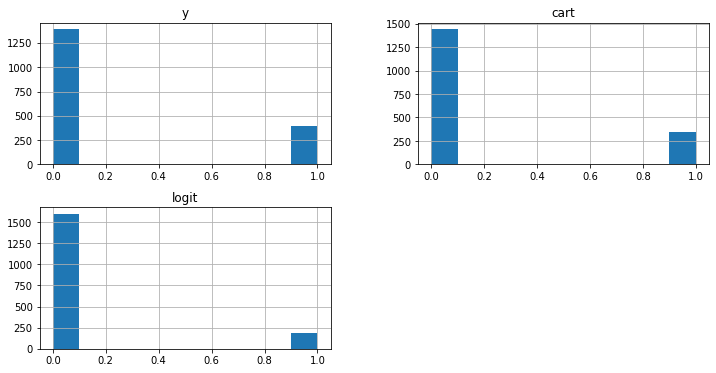

In [ ]:
# We collect predictions into a dataframe for easy visualization
df_pred = pd.DataFrame({'y': y_test, 'cart': tree.predict(X_test), 'logit': logit.predict(X_test)})  
df_pred.hist();

How to interpret these graphs? Well, many points are noteworthy:
- the data is imbalanced, $y$ shows less ones (bad clients) than zeros (good clients).
- CART and logit pick-up the imbalance and predict class 0 more often.
- CART and logit indeed predict classes. All predictions are either zero or one, and never anything in between.

Given the latter point, let's create some probabilistic predictions using the function `predict_proba()`. Remember that `sklearn` classification models routinely offer both functions, `predict()` and `predict_proba()`, for producing discrete and probabilistic predictions, respectively.

In [ ]:
# Add probabilistic predictions to our dataframe
p = logit.predict_proba(X_test)
print(p)  # this is a 2D array

[[0.93186683 0.06813317]
 [0.93798714 0.06201286]
 [0.73778796 0.26221204]
 ...
 [0.96003058 0.03996942]
 [0.85082524 0.14917476]
 [0.52209895 0.47790105]]


Note that the result `p`, which we compute above, is an $n \times 2$ array. An array was to be expected as we calculate predictions for the $n$ data instances (rows) in $X$. But why have two outputs per data instance? Well, the answer is that we have two classes, and get probability estimates for each of these classes. When storing model predictions for later use, we only need the probabilities for one of the classes. Always make sure you **understand which class predictions you keep.** Examining the `classes_` attribute of a model class helps us.   

In [ ]:
print(logit.classes_)

[0 1]


This says that we have two classes with class labels zero and one, respectively. Thus, to extract the estimated probabilities of the class with label zero, we can call `p[:,0]`. Likewise, `p[:,1]` gives the estimated membership probabilities of the second class with the label one. This is a bit complicated in the beginning but we have to get used to it. Below, we combine the indexing directly with calling `predict_proba()`, which is common practice, and keep the predictions associated with the second class. In our data, the class label one indicates that a borrower was a bad risk.

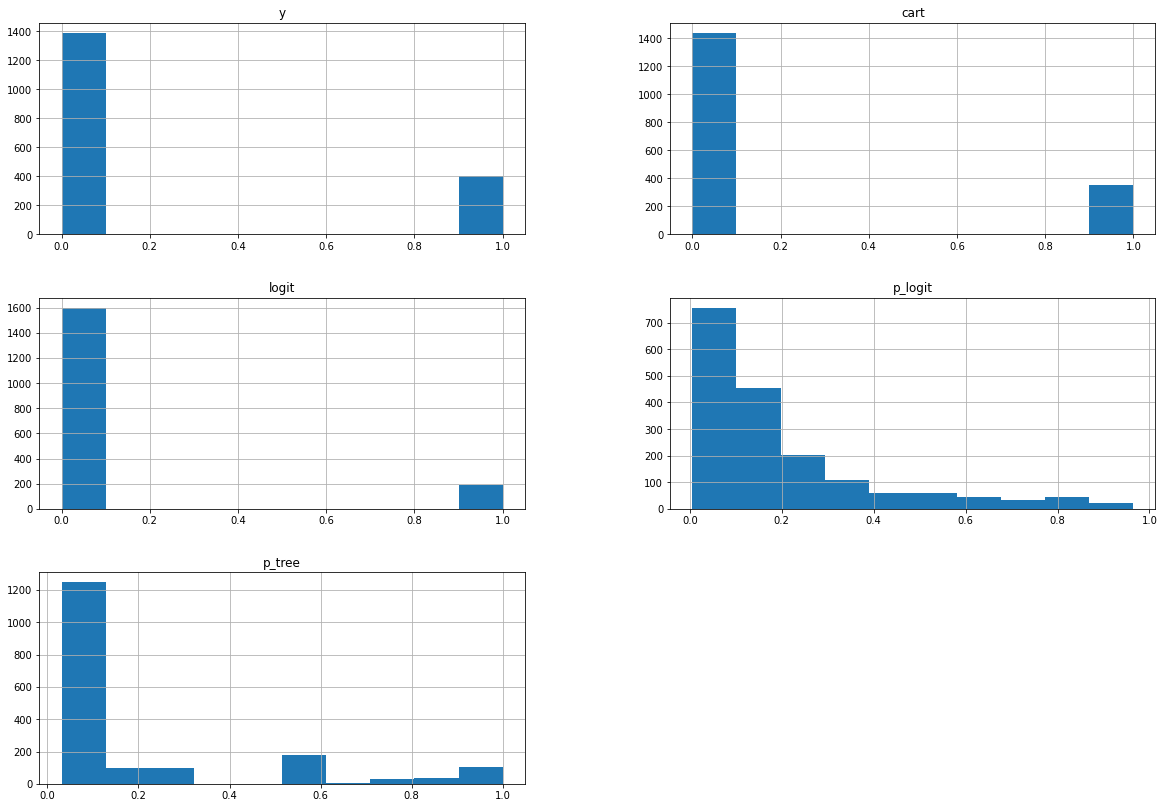

In [ ]:
# Augment data frame with predictions
df_pred["p_logit"] = p[:,1]
df_pred["p_tree"] = tree.predict_proba(X_test)[:,1]

# Also plot the probabilistic predictions
df_pred.hist(figsize=(20,14));

Did you notice the different distribution of the predictions from the logit model compared to the tree model in the histograms? One could draw several conclusions from the plots. Make sure to think about and understand the following statement:

*The number of distinct values among the probability estimates coming from the tree is upper bounded by (and often equivalent to) the number of leaf nodes in a classification tree*

We will not elaborate on that statement here, but, at least, verify the claim empirically.

In [ ]:
# Calculate the number of distinct values among the tree predictions
n_p_tree =  len(np.unique(df_pred["p_tree"]))
print('The number of unique predictions from the tree is: {}.'.format(n_p_tree))

# Extract the size of the tree in terms of the number of nodes
print('The number of leaf nodes in the tree is: {}.'.format(tree.get_n_leaves()))


The number of unique predictions from the tree is: 15.
The number of leaf nodes in the tree is: 23.


So here, there are more leaf nodes than unique predictions, which is consistent with the above statement. Why does it has to be like that? Fair enough if you find the question trivial, but we want to make sure you fully understand how trees predict probabilities. 

## Measures of predictive accuracy 
Accuracy indicators help us evaluate how well our model predicts the target. We compute them by **comparing actuals to predictions**. One easy way to do so is by using the `score()` function.

In [ ]:
print('Logit model scores {:.4}'.format(logit.score(X_test, y_test)))
print('Tree model scores {:.4}'.format(tree.score(X_test, y_test)))

Logit model scores 0.8121
Tree model scores 0.882


Wow, so easy. Really? Yes! But what actually is that score? Are higher scores better or should the score be low? We call functions like `score()` convenience functions. They are easy to use but hide many - often important - details. Look into the help to see what `score()` is really computing. 

Ok, **after reading the help** you now know that `score()` calculates *classification accuracy*. We defined that measure in the lecture as
$$ \frac{TP+TN}{P+N}$$
whereby the TP, TN denote the number of true positive and true negative classifications and T and N represent the real number of positives and negatives. 

But is the accuracy score really helpful here?

### Confusion matrix
A confusion matrix is a cross-table of predicted and actual classes. As such, it provides more insight into a classifier compared to the classification accuracy measure, which summarizes the whole confusion table in a single number.

In [ ]:
from sklearn import metrics  # Important lib where we find various performance measures

# 1. Quick and dirty way to get a confusion table
cmat = metrics.confusion_matrix(y_test, logit.predict(X_test)) 
print(cmat)

[[1326   63]
 [ 273  126]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


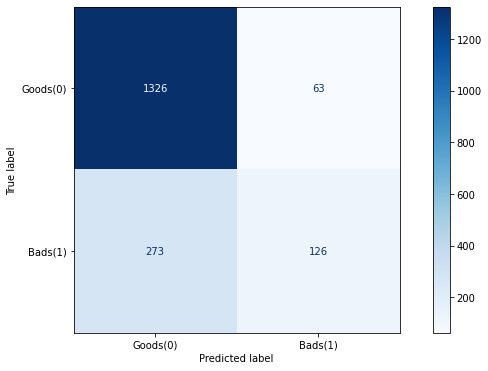

In [ ]:
# 2. Pretty-print confusion matrix
metrics.plot_confusion_matrix(logit, X_test, y_test, labels=[0, 1], 
                              display_labels=['Goods(0)', 'Bads(1)'], cmap='Blues',values_format='n')
plt.show()

Classification accuracy simply calculates the number of correct class predictions (main diagonal) over all cases. Correct predictions are twofold. We can classify a good customer as good customer and we can classify a bad customer as bad customer. Likewise, our classifier can make two errors, classifying an actually good customer as bad and classifying an actually bad customer as good. We find the numbers of these errors in the off-diagonal of the confusion matrix.

A good model will maximize the **True Positive Rate**,

$$TPR=\frac{TP}{P},$$

and the **True Negative Rate**,

$$TNR=\frac{TN}{N},$$

where P and N denote the real number of positives and negatives, respectively.

Evaluation metrics that pick up the idea of looking simultaneously at the two metrics TPR and TNR are the balanced accuracy (BA), 

$$BA=\frac{TPR+TNR}{2},$$

as well as the 

**F1-Score** 

and the **ROCAUC** score. 

ROCAUC is short for Receiver Operating Characteristic Area under the Curve. 

In cases with highly imbalanced class distribution (like the credit dataset at hand) it can be very instructive to look at scores that take into account the individual class accuracies to better balance them out. Let's consider an example:

Suppose you have 100% TPR and 0% TNR. In case of equally distributed positives and negatives in your data (50% P and 50% N) this means **50% accuracy** and **50% balanced accuracy**. However, suppose you have 80% positives and just 20% negatives. This translates to **80% accuracy** but still just **50% balanced accuracy**. To get 80% balanced accuracy, you would need 60% TNR instead of the 0%! Hence, depending on your problem, your classifier might not be as good as the accuracy suggests!


In [ ]:
# the balanced accuracy:
print('logistic regr bal. acc score on test: ' +  str(
    metrics.balanced_accuracy_score(y_test, logit.predict(X_test))) )
print('tree bal. acc score on test: ' +  str(
    metrics.balanced_accuracy_score(y_test, tree.predict(X_test))) )

# the F1 score:
print('logistic regr f1 score on test: ' +  str(
    metrics.f1_score(y_test, logit.predict(X_test))) )
print('tree f1 score on test: ' +  str(
    metrics.f1_score(y_test, tree.predict(X_test))) )

# the ROCAUC score:
print('logistic regr ROCAUC score on test: ' +  str(
    metrics.roc_auc_score(y_test, logit.predict_proba(X_test)[:,1])) )
print('tree ROCAUC score on test: ' +  str(
    metrics.roc_auc_score(y_test, tree.predict_proba(X_test)[:,1])) )

logistic regr bal. acc score on test: 0.6352165510969648
tree bal. acc score on test: 0.8079350644429648
logistic regr f1 score on test: 0.42857142857142855
tree f1 score on test: 0.7182910547396529
logistic regr ROCAUC score on test: 0.7926980879123655
tree ROCAUC score on test: 0.8747002495439462


We see that the overreliance on one class gets punished a lot in some scores.

# Model Selection via Cross-validation
Cross validation is an extension of the split sample method. It consists of repeating the train data split multiple times.

Step by step:
- Randomly split training data in N disjoint folds (E.g., N=5) 
- Build model on N-1 folds 
- Apply trained model to produce predictions for cases in the left-out fold (i.e., validation sample) 
- Measure model performance by comparing actuals to predictions using the validation sample
- Repeat the above steps N times 
- Average model performance over the N validation folds  
- You can also estimate the standard deviation of model performance (e.g., for statistical hypothesis testing)

Unlike the split sample (holdout) approach, cross-validation considers all training (plus validation/development) data for model building and validation and is, therefore, more efficient in its use of the available data. It's called exhaustive for this reason. 

## Decision Tree Hyperparameter Tuning with Cross-Validation


In [ ]:
from sklearn.ensemble import RandomForestClassifier  # import library
from sklearn.model_selection import GridSearchCV

print('Tuning decision tree classifier')
dtree = DecisionTreeClassifier(criterion='gini',random_state=888)

# Define meta-parameter grid of candidate settings
# The following settings are just for illustration
param_grid = {
              'max_depth': [2,5,7,10,20,30]
              }

# Set up the grid object specifying the tuning options
gs_dt = GridSearchCV(dtree, param_grid, cv=5, scoring='roc_auc', verbose=1)
gs_dt.fit(X_train, y_train.values.ravel())


Tuning decision tree classifier
Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=888),
             param_grid={'max_depth': [2, 5, 7, 10, 20, 30]}, scoring='roc_auc',
             verbose=1)

In [ ]:
# but what are the optimal params (as per CV)?
gs_dt.best_params_

{'max_depth': 7}

Let's check the performance vs. the logistic reg and the decision tree without hyperparameter optimization with the CV.

In [ ]:
print('dec. tree regr ROCAUC score on test: ' +  str(metrics.roc_auc_score(y_test, tree.predict_proba(X_test)[:,1])) )
print('logistic regr ROCAUC score on test: ' +  str(metrics.roc_auc_score(y_test, logit.predict_proba(X_test)[:,1])) )
print('optimal dec. tree ROCAUC score on test: ' +  str(metrics.roc_auc_score(y_test, gs_dt.predict_proba(X_test)[:,1])) )

dec. tree regr ROCAUC score on test: 0.8747002495439462
logistic regr ROCAUC score on test: 0.7926980879123655
optimal dec. tree ROCAUC score on test: 0.8803803966359384


The hyperparameter tuning worked. The optimized model generalizes slightly better than the decision tree with depth 5. Not a landslide victory, though. 

## A Note on Overfitting 

To see a really good example of a model that can easily be overfit, we can take a look at decision trees. Decision trees are rather complex and highly nonlinear models. When trees are grown too deep, they start to internalize idiosyncacies (noise) of the specific data that they were fed. This means that they "assume" that all little random variations in the train data will occur in test sets as well.

Let's take a look at what this looks like by generating a tracking the AUC of a decision tree on training and test data as we increase the **depth** of the tree.

In [ ]:
from sklearn import tree

train_auc_list = []
test_auc_list = []

for n in range(1,30):
  # Fit tree to training data
  dt = tree.DecisionTreeClassifier(max_depth=n, random_state=888)
  dt = dt.fit(X_train, y_train)
  
  # Predictions and metrics for training data
  dt_train_pred = dt.predict(X_train)
  auc = metrics.roc_auc_score(y_train, dt_train_pred)
  train_auc_list.append(auc)
  
  # Predictions and metrics for test data
  dt_test_pred = dt.predict(X_test)
  auc = metrics.roc_auc_score(y_test, dt_test_pred)
  test_auc_list.append(auc)

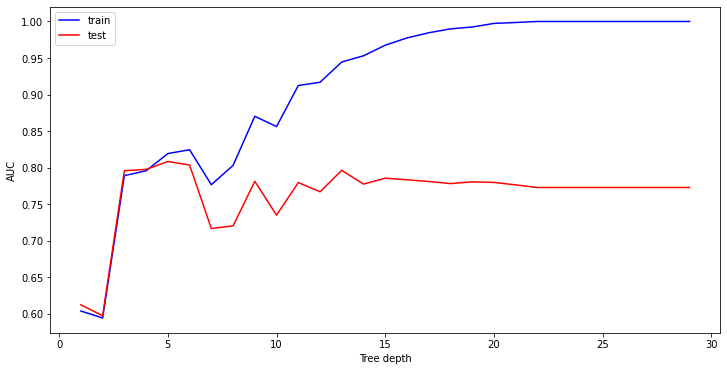

In [ ]:
plt.plot(range(1,30), train_auc_list, c='b', label="train")
plt.plot(range(1,30), test_auc_list, c='r', label="test")
plt.ylabel("AUC")
plt.xlabel("Tree depth")
plt.legend(loc="best")
plt.show()

Almost textbook! Apparently an ever increasing complexity (tree depth) does not lead to better generalization. Instead, the optimal tree depth that gives good generalization on the test dataset is around 5-7. 

# Regression

In statistical modeling, regression analysis is a set of statistical processes for estimating the relationships between a **continuous** dependent variable (often called the 'outcome' or 'response' variable, or a 'label' in machine learning parlance) and one or more independent variables (often called 'predictors', 'covariates', 'explanatory variables' or 'features'). The most common form of regression analysis is linear regression, in which one finds the line (or a more complex linear combination) that most closely fits the data according to a specific mathematical criterion. 

In predictive analytics, regression will always refer to problems involving a non-categorical (but continuous) dependent variable, i.e. a dependent variable that can attain any real number. An example would be the turnover of a large shop (like amazon) which can be anything from 0 cents in the startup phase to multi-billion dollars.

In [ ]:
df = pd.read_csv('https://www.dropbox.com/s/pvroyzt1ctdxjvy/insurance.csv?dl=1')

# Split data into target and features
pd_X = df.drop(['charges'], axis=1) 
pd_y = df['charges'].astype(int)  # also make the target an integer value

# no dev set this time, we will use cross-validation on the train data
X_train, X_test, y_train, y_test = train_test_split( pd_X, pd_y, test_size=0.3, random_state=23)

y_train_0, y_test_0 = y_train, y_test

# a train data set
df_train = X_train.merge(y_train, left_index = True, right_index = True)

df.head(5) 

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Let's check the variable types:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


The dependent variable will be the charges. Let's take a closer look. 

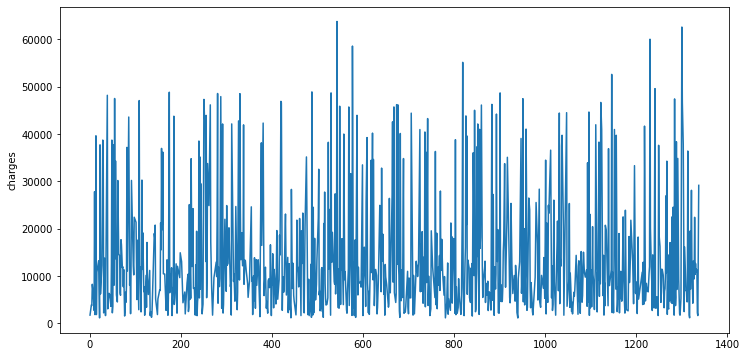

In [ ]:
# plot of the charges vs observation number
sns.lineplot(x=df_train.index, y = df_train['charges'])

The data type object flags already that we might have an issue in these columns. Let's do proper data-preprocessing first.

## Data Pre-Processing Review

We want to address three issues with the data:

1) spotting and replacing missing values (if there are any)

2) apply box-cox-type transforms where needed

3) decide whether outlier-correction is needed

4) encode the categorical variables

Let's first plot histograms of the numerical variables in order to answer 2+3.

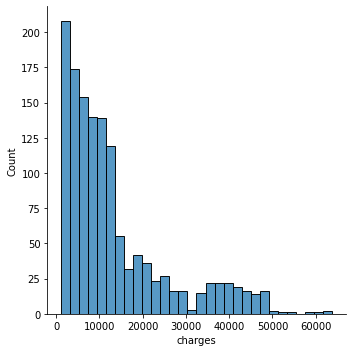

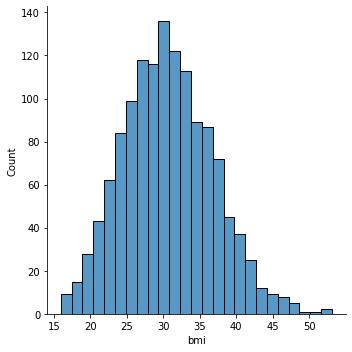

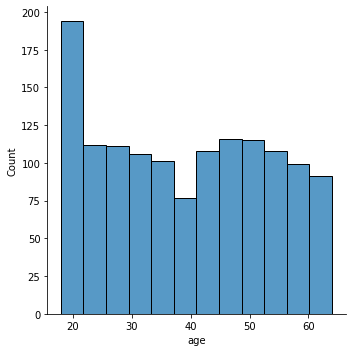

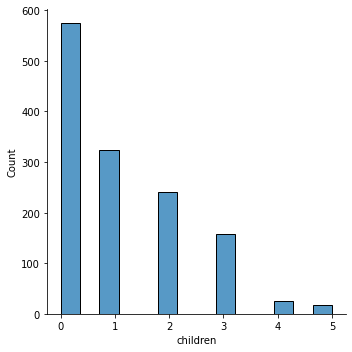

In [ ]:
# plot the distributions ... 
sns.displot(df['charges']); sns.displot(df['bmi']); sns.displot(df['age']); sns.displot(df['children']); 

### Your Code for Data Pre-Processing!

In [ ]:
# 1
# spotting missing values
# remember the line from the data-preprocessing notebook:

# sns.heatmap(df.isnull(), cbar=False);  # quick visualization of the missing values in our data set
# df.isnull().sum().sum() # count the numbers


In [ ]:
# 2
# box cox type transforms
# the sklearn code for a feature
# bc_fitted_feature, opt_lambda = scipy.stats.boxcox(feature+1) # Again, we are adding 1 because all features have 0s (not allowed in BC)


In [ ]:
# 3
# outlier cleaning
# Do we have a problem? If so, use the method from the data_preprocessing notebook
# One boxplot for each variable
#
## first plot the interquartile ranges (box-plot!)
# num_vars = df.select_dtypes(exclude=['object'])
# num_vars.plot(kind = 'box', subplots=True);

# the custom function to handle outliers 
def outlier_truncation(x, factor=1.5):
    '''
    Identifies outlier values based on the inter-quartile range IQR. 
    Corresponding outliers are truncated and set to a contant value equal to the IQR
    times a factor, which, following Tuckey's rule, we set to 1.5 by default
    
        Parameters:
            x (Pandas Series): A data frame column to scan for outliers
            factor (float): An outlier is a value this many times the IQR above q3/below q1
            
        Returns:
            Adjusted variable in which outliers are truncated
    '''
    x_new = x.copy()
    
    # Calculate IQR
    IQR = x.quantile(0.75) - x.quantile(0.25) 
    
    # Define upper/lower bound
    upper = x.quantile(0.75) + factor*IQR
    lower = x.quantile(0.25) - factor*IQR
    
    # Truncation
    x_new[x < lower] = lower
    x_new[x > upper] = upper
    
    return x_new



In [ ]:
# 4
# encode the categorical variables
# we have to apply this to the full dataset
train_len = len(X_train)
# full data
X_full = pd.concat(objs=[X_train, X_test], axis=0)

## remember the old encoding code from the data preprocessing notebook:
# X_full = pd.get_dummies(X_full, columns = ['REASON', 'JOB'], drop_first=True)
# X_train_dummies = X_full[:train_len]
# X_test_dummies = X_full[train_len:]


## Data Pre-Processing Solution

## Training the Prediction Model

In [ ]:
# Scikit Learn regression
from sklearn.linear_model import LinearRegression
# metrics for regression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# intercept fitted automatically
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train) 


LinearRegression()

## Prediction: Producing the Forecasts

In [ ]:
# quite simple, take trained model and predict based on the X_test data
y_pred = lin_reg.predict(X_test) 

## Evaluation via Prediction Metrics for Regression Problems

- sometimes in pure linear regression problems: $R^2$, the **coefficient of determination**
- MSE / RMSE, the mean squared error / root mean squared error
- MAE, the mean absolute error

Compare to MSE or RMSE, MAE is a more direct representation of sum of error terms. MSE gives larger penalization to big prediction error by square it while MAE treats all errors the same.

The coefficient of determination can be more (intuitively) informative than MAE, MSE, and RMSE in regression analysis evaluation, as the former can be expressed as a percentage, whereas the latter measures have arbitrary ranges.

It also gives the explained variability of the dependent variable.
Suppose $R^2$ = 0.49. This implies that 49% of the variability of the dependent variable in the data set has been accounted for, and the remaining 51% of the variability is still unaccounted for. 

In [ ]:
print('R2 prediction based on test sample: '+ str(r2_score(y_pred,y_test)))
print('MAE prediction based on test sample: '+str(mean_absolute_error(y_pred,y_test)))
print('MSE prediction based on test sample: '+str(mean_squared_error(y_pred,y_test)))

# in sample
y_pred_train = lin_reg.predict(X_train)
print('R2 train: '+str( r2_score(y_pred_train,y_train)))
print('MAE train: '+str(mean_absolute_error(y_pred_train,y_train)))
print('MSE train: '+str(mean_squared_error(y_pred_train,y_train)))

R2 prediction based on test sample: 0.6823967384826777
MAE prediction based on test sample: 0.4555758122605591
MSE prediction based on test sample: 0.49374122483096605
R2 train: 0.6958820071680338
MAE train: 0.45571632043512467
MSE train: 0.5177361227860144


## Appendix: no feature transformation

In [ ]:
# alternative without box-cox:
lin_reg_0 = LinearRegression()
lin_reg_0.fit(X_train,y_train_0) 
y_pred_0 = lin_reg_0.predict(X_test) 

In [ ]:
print('R2 prediction based on test sample: '+ str(r2_score(y_pred_0,y_test_0)) )
print('MAE prediction based on test sample: '+ str(mean_absolute_error(y_pred_0,y_test_0)) )
print('MSE prediction based on test sample: '+ str(mean_squared_error(y_pred_0,y_test_0)) )

# in sample
y_pred_train_0 = lin_reg_0.predict(X_train)
print('R2 train: '+ str(r2_score(y_pred_train_0,y_train_0)))
print('MAE train: '+ str(mean_absolute_error(y_pred_train_0,y_train_0)) )
print('MSE train: '+ str(mean_squared_error(y_pred_train_0,y_train_0)) )

R2 prediction based on test sample: 0.6616303903371634
MAE prediction based on test sample: 4040.50165210941
MSE prediction based on test sample: 35313256.35329582
R2 train: 0.6792607599368484
MAE train: 4214.443150504788
MSE train: 37163048.225228064
